# A Meta-Framework for Outlier Detection in Distributed Data

## FashionMNIST-Experiment

In [1]:
# import packages
import copy
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

import numpy as np
import pandas as pd

from syft.federated.floptimizer import Optims

import syft as sy
from syft.frameworks.torch.fl import utils
hook = sy.TorchHook(torch)

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Define network size, batch size and learning rate

In [2]:
NUM_CLIENTS = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

Some utility functions

In [12]:
# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:1'
    else:
        device = 'cpu'
    return device


def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
        

def save_model(model, name):
    model_dir = 'FashionMNIST_MODELS'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    torch.save(model.state_dict(), os.path.join(model_dir, name + ".pth"))
    

def load_model(name):
    model_path = os.path.join("FashionMNIST_MODELS", name + ".pth")
    state_dict = torch.load(model_path)
    if name.startswith("one_layer_ae"):
        model = OneLayerAutoencoder()
    if name.startswith("multi_layer_ae"):
        model = MultiLayerAutoencoder()
    if name.startswith("conv_ae"):
        model = ConvolutionalAutoencoder()
    model.load_state_dict(state_dict)
    return model

        
def save_decoded_image(img, comm, epoch, batch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image_{}_{}_{}.png'.format(comm, epoch, batch))
    
    
def federate(dataset, num_clients):
    rand_indices = torch.randperm(dataset.data.size(0))
    splitted_indices = torch.split(rand_indices, int(rand_indices.size(0) / num_clients))
    splitted_data = [torch.utils.data.Subset(dataset, share) for share in splitted_indices]
    data_loaders = [torch.utils.data.DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True) 
                   for subset in splitted_data]
    return data_loaders


def get_averaged_weights(models):
    with torch.no_grad():
        result_state_dict = models[0].state_dict()
        layer_keys = result_state_dict.keys()
        for key in layer_keys:
            all_weights = [model.state_dict()[key] for model in models]
            result_state_dict[key] = torch.mean(torch.stack(all_weights), dim=0)
        return result_state_dict


print("Device is {}".format(get_device()))


def federate(dataset, num_clients):
    rand_indices = torch.randperm(dataset.data.size(0))  # create random indices up to 60000
    splitted_indices = torch.split(rand_indices, int(rand_indices.size(0) / num_clients))
    splitted_data = [torch.utils.data.Subset(dataset.data, share) for share in splitted_indices]
    subset_image = splitted_data[0].dataset[splitted_data[0].indices[0]]
    plt.imshow(subset_image)
    plt.show()
    plt.imshow(dataset.data[splitted_data[0].indices[0]])
    plt.show()
    return splitted_data


def train(model, data, optimizer):
    recon = model(data)
    loss = criterion(recon, data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return model, float(loss)

Device is cuda:1


In [4]:
def federate(dataset, num_clients):
    num_examples = dataset.data.size(0)  # 600000
    partition_size = int(num_examples / num_clients)  # 6000
    examples_per_split = [partition_size for _ in range(num_clients)]
    data = dataset.data[:partition_size*num_clients]
    splitted_data = torch.utils.data.random_split(data, examples_per_split)
    subset_image = splitted_data[0].dataset[splitted_data[0].indices[0]]
    plt.imshow(subset_image)
    plt.show()
    plt.imshow(dataset.data[splitted_data[0].indices[0]])
    plt.show()
    return splitted_data

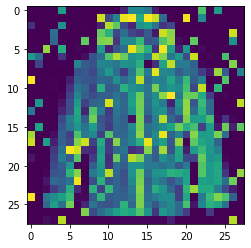

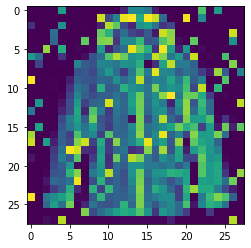

In [13]:
federate(mnist_data, 5)

In [ ]:
def federate(dataset, num_clients):
    num_examples = dataset.data.size(0)  # 600000
    partition_size = int(num_examples / num_clients)  # 6000
    examples_per_split = [partition_size for _ in range(num_clients)]
    data = dataset.data[:partition_size*num_clients]
    splitted_data = torch.utils.data.random_split(data, examples_per_split)
    return splitted_data

Autoencoder classes

In [5]:
class OneLayerAutoencoder(nn.Module):
    def __init__(self):
        super(OneLayerAutoencoder, self).__init__()
        self.enc = nn.Linear(in_features=784, out_features=128)
        self.dec = nn.Linear(in_features=128, out_features=784)

    def forward(self, x):
        x = F.relu(self.enc(x))
        x = torch.sigmoid(self.dec(x))
        return x


class MultiLayerAutoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.sigmoid(self.dec5(x))
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Functions for adding outliers

In [63]:
class OutlierWithProbability(object):
    
    def __init__(self, probability, transform):
        assert isinstance(probability, float)
        self.prob = probability
        self.transform = transform
        
    def __call__(self, sample):
        is_batch = len(sample.size()) > 2
        if is_batch:
            old_shape = sample.size()
            output = [OutlierWithProbability(self.prob, self.transform)(image) for image in sample]
            images = [out[0] for out in output]
            labels = [out[1] for out in output]
            images = np.array(images)
            labels = np.array(labels)
            images = np.reshape(images, old_shape)
            labels = np.reshape(labels, old_shape)
            images = torch.from_numpy(images)
            return images, labels
        if np.random.uniform() > self.prob:
            return sample, np.zeros(sample.size()).astype(int)
        return self.transform(sample)


class BrightnessShift(object):
    """Shift brightness of input image.

    Args:
        shift (tuple or float): Desired output size. If int, fixed shift is applied. 
        If tuple, random value between (min, max).
    """

    def __init__(self, shift):
        assert isinstance(shift, (float, tuple))
        if isinstance(shift, float):
            self.shift = (shift, shift)
        else:
            assert len(shift) == 2
            self.output_size = shift

    def __call__(self, sample):
        image = sample
        random_shift = np.random.uniform(low=self.shift[0], high=self.shift[1])
        image = torch.add(image, random_shift)
        image = torch.div(image, torch.max(image))
        return image, np.ones(image.shape)
    

class InvertImage(object):
    """Invert brightness; white --> black, black --> white.
    """

    def __call__(self, sample):
        image = sample
        image = torch.mul(image, -1.0)
        image = torch.add(image, 1.0)
        return image
    

class RandomOutliers(object):
    """Add random noise 
    Args: 
        percentage (float): Percentage of outlier pixels
    """
    
    def __init__(self, percentage, subspace_fraction):
        assert isinstance(percentage, float)
        assert isinstance(subspace_fraction, float)
        self.percentage = percentage
        self.subspace_fraction = subspace_fraction
    
    def __call__(self, sample):
        is_batch = len(sample.size()) == 4
        if is_batch:
            old_shape = sample.size()
            output = [RandomOutliers(self.percentage, self.subspace_fraction)(image) for image in sample]
            images = [out[0] for out in output]
            images = np.array(images)
            images = np.reshape(images, old_shape)
            images = torch.from_numpy(images)
            return images
        
        if np.random.uniform() > self.percentage:
            return sample
        outlier_mask = np.random.binomial(n=1, 
                                          p=self.subspace_fraction, 
                                          size=sample.size())
        noise = np.random.uniform(size=sample.size())
        outlier_mask = torch.from_numpy(outlier_mask)
        noise = torch.from_numpy(noise)
        sample = noise*outlier_mask + (1-outlier_mask)*sample
        return sample

### Data

- add outliers
- assign boolean labels to targets of mnist data set

TypeError: Image data of dtype object cannot be converted to float

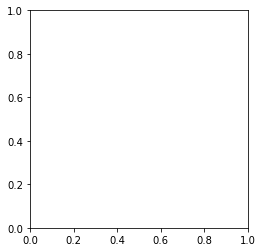

In [64]:
base_transforms_list = [
    # transforms.RandomRotation(90, fill=(0,)),
    # transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    RandomOutliers(percentage=1.0, subspace_fraction=0.2),
]
base_transform = transforms.Compose(base_transforms_list)

mnist_data = datasets.FashionMNIST('../data', train=True, download=True,
                                   transform=base_transform)

plt.imshow(mnist_data)

plt.show()

In [ ]:
[print(data) for data in mnist_data]

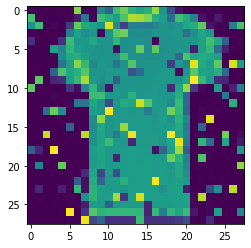

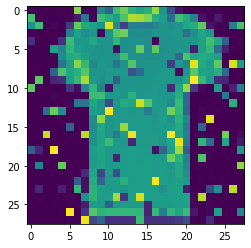

ValueError: too many values to unpack (expected 2)

In [103]:
# CONFIGURATION
COMMUNICATION_ROUNDS = 5
LOCAL_EPOCHS = 2
MODEL_NAME = "conv_ae" # "multi_layer_ae" "conv_ae"

# CREATE MODEL, FEDERATE DATA AND MODELS
if MODEL_NAME == "one_layer_ae":
    base_model = OneLayerAutoencoder()
if MODEL_NAME == "multi_layer_ae":
    base_model = MultiLayerAutoencoder()
if MODEL_NAME == "conv_ae":
    base_model = ConvAutoencoder()

base_model.to(get_device())
base_model.train()
models_federated = [base_model.copy() for _ in range(NUM_CLIENTS)]
models_local = [base_model.copy() for _ in range(NUM_CLIENTS)]
base_model_federated = base_model.copy()  # this instance will be redistributed from server to clients

outlying_devices = []

federated_data = federate(mnist_data, NUM_CLIENTS)

for data in federated_data[0]:
    img, _ = data
    print(img.size())
    plt.imshow(img[0, :, :])
    plt.show()

# ADD LOCAL OUTLIERS TO FEDERATED DATA
DEVICES_WITH_LOCAL_OUTLIERS = np.arange(1)
LOCAL_OUTLIER_PROBABILITY = 0.01
OCCURENCE_PROBABILITY_GENERAL = 0.2

brightness_shift = BrightnessShift(0.5)

"""
for client, partition in enumerate(federated_data):
    data_indices = partition.indices
    altered_data = partition.dataset.data[partition.indices]
    altered_targets = np.array(partition.dataset.targets[partition.indices]).astype(int)
    if client in DEVICES_WITH_LOCAL_OUTLIERS:
        altered_data, targets = OutlierWithProbability(LOCAL_OUTLIER_PROBABILITY, 
                                                       brightness_shift)(altered_data)
        targets = np.any(targets, axis=(-1, -2))
        altered_targets[targets > 0] = targets[targets > 0] + 1
        federated_data[client].dataset.targets[data_indices] = torch.from_numpy(altered_targets)
    else:
        altered_data, _ = OutlierWithProbability(OCCURENCE_PROBABILITY_GENERAL, 
                                                       brightness_shift)(altered_data)
    federated_data[client].data = altered_data
"""

# CREATE DATA LOADER FOR EACH CLIENT
data_loaders = [torch.utils.data.DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True) 
                for subset in federated_data]

# for batch in data_loaders[0]:
#     img, _ = batch
#     plt.imshow(img[0][0])
#     plt.show()

# THE CRITERION
criterion = nn.MSELoss()

# CREATE OPTIMIZER INSTANCE FOR EACH MODEL THAT WE TRAIN
optimizers_federated = [
    torch.optim.Adam(models_federated[i].parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    for i in range(NUM_CLIENTS)
]
optimizers_local = [
    torch.optim.Adam(models_local[i].parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    for i in range(NUM_CLIENTS)
]

for client in outlying_devices:
    client_data = data_loaders[client].dataset
    data_loaders[client] = DataLoader(client_data, batch_size=BATCH_SIZE, shuffle=True)

# FIT THE OUTLIER DETECTORS
loss_df = []

for comm_round in range(COMMUNICATION_ROUNDS):
    for client in range(NUM_CLIENTS):
        loader = data_loaders[client]
        model_c = models_federated[client]
        model_l = models_local[client]
        optimizer_c = optimizers_federated[client]
        optimizer_l = optimizers_local[client]
        for epoch in range(LOCAL_EPOCHS):
            for batch_idx, data in enumerate(loader):
                img = data
                if client in outlying_devices:
                    img = InvertImage()(img)
                img = img.to(get_device())
                if not MODEL_NAME == "conv_ae":
                    img = img.view(img.size(0), img.size(1)*img.size(2)*img.size(3))
                model_c, loss_c = train(model_c, img, optimizer_c)
                model_l, loss_l = train(model_l, img, optimizer_l)
                models_federated[client] = model_c
                models_local[client] = model_l
                if batch_idx % 100 == 0:
                    print('Comm round {}, Client {}, Epoch:{}, Batch:{}, Loss_c:{:.4f}, Loss_l:{:.4f}'
                          .format(comm_round+1, 
                                  client+1,
                                  epoch+1, 
                                  batch_idx+1, 
                                  loss_c, 
                                  loss_l))
                    if client == 0:
                        plt.imshow(img.cpu()[0].view(28, 28))
                        plt.show()
                        save_decoded_image(img, comm_round, epoch, batch_idx)
                loss_df.append([client, comm_round, epoch, batch_idx, client in outlying_devices, loss_c])
    new_state_dict = get_averaged_weights(models_federated)
    base_model_federated.load_state_dict(new_state_dict)
    models_federated = [base_model_federated.copy() for _ in range(NUM_CLIENTS)]
    optimizers = [
        torch.optim.Adam(models_federated[i].parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        for i in range(NUM_CLIENTS)
    ]

### Model training

### Store models

In [ ]:
save_model(base_model_federated, MODEL_NAME + "_c")
[save_model(model, MODEL_NAME + "_l_{}".format(i)) for i, model in enumerate(models_local)]
[torch.save(loader, os.path.join("FashionMNIST_MODELS", "loader_{}.pth".format(i))) for i, loader in enumerate(data_loaders)]

## Evaluation

### Load models

First we reload the previously trained models and the data loaders.
Note that the `base_model_federated` is sufficient, as *C* is identical for all clients

In [ ]:
base_model_federated = load_model(MODEL_NAME + "_c")
models_local = [load_model(MODEL_NAME + "_l_{}".format(i)) for i in range(NUM_CLIENTS)]
data_loaders = [torch.load(os.path.join("FashionMNIST_MODELS", "loader_{}.pth".format(i))) for i in range(NUM_CLIENTS)]

[model.eval() for model in models_local]
base_model_federated.eval()

## Global and local outliers

### Compute outlier scores

Let us first compute the outlier scores (mean squared error) for all images we trained on.

In [ ]:
criterion = nn.MSELoss()
outlier_scores_c = []
outlier_scores_l = []
ground_truth = []
with torch.no_grad():
    for client in range(NUM_CLIENTS):
        print("Inferencing on client {}".format(client))
        model_c = base_model_federated.to(get_device())
        model_l = models_local[client].to(get_device())
        for batch_idx, batch in enumerate(data_loaders[client]):
            data, targets = batch
            data = data.to(get_device())
            if not MODEL_NAME == "conv_ae":
                data = data.view(data.shape[0], -1)
            pred_c = model_c(data)
            pred_l = model_l(data)
            os_c = [float(criterion(recon, original)) for recon, original in zip(pred_c, data)]
            os_l = [float(criterion(recon, original)) for recon, original in zip(pred_l, data)]
            outlier_scores_c += list(os_c)
            outlier_scores_l += list(os_l)
            ground_truth += list(targets)
outlier_scores_c = np.array(outlier_scores_c)
outlier_scores_l = np.array(outlier_scores_l)
ground_truth = np.array(ground_truth)

We check the mean outlier scores of in- and outliers:

In [ ]:
is_normal = ground_truth == 0
is_local_outlier = ground_truth == 2
is_global_outlier = ground_truth == 1
print(np.any(is_normal))
print(np.any(is_local_outlier))
print(np.any(is_global_outlier))

In [ ]:
mean_os_normal_c = np.mean(outlier_scores_c[is_normal])
mean_os_local_outliers_c = np.mean(outlier_scores_c[is_local_outlier])
mean_os_global_outliers_c = np.mean(outlier_scores_c[is_global_outlier])

mean_os_normal_l = np.mean(outlier_scores_l[is_normal])
mean_os_local_outliers_l = np.mean(outlier_scores_l[is_local_outlier])
mean_os_global_outliers_l = np.mean(outlier_scores_l[is_global_outlier])

print("OS_C of inliers:  {:.4f}".format(mean_os_normal_c))
print("OS_C of local outliers: {:.4f}".format(mean_os_local_outliers_c))
print("OS_C of global outliers: {:.4f}".format(mean_os_global_outliers_c))

print("OS_L of inliers:  {:.4f}".format(mean_os_normal_l))
print("OS_L of local outliers: {:.4f}".format(mean_os_local_outliers_l))
print("OS_L of global outliers: {:.4f}".format(mean_os_global_outliers_l))

In [ ]:
data_indices = np.array([i for i in range(len(outlier_scores_c))])
inlier_indices = data_indices[is_normal]
local_outlier_indices = data_indices[is_local_outlier]
global_outlier_indices = data_indices[is_global_outlier]

fig, axes = plt.subplots(2, 1, sharex="all")
axes[0].scatter(np.array([i for i in range(len(outlier_scores_c))])[inlier_indices], 
                outlier_scores_c[inlier_indices], 
                alpha=0.005)
axes[0].scatter(np.array([i for i in range(len(outlier_scores_c))])[local_outlier_indices], 
                outlier_scores_c[local_outlier_indices], 
                alpha=0.05)
axes[0].scatter(np.array([i for i in range(len(outlier_scores_c))])[global_outlier_indices], 
                outlier_scores_c[global_outlier_indices], 
                alpha=0.05)
axes[0].set_title("Collective outlier detection")
axes[1].scatter(np.array([i for i in range(len(outlier_scores_c))])[inlier_indices], 
                outlier_scores_l[inlier_indices], 
                alpha=0.005)
axes[1].scatter(np.array([i for i in range(len(outlier_scores_c))])[local_outlier_indices], 
                outlier_scores_l[local_outlier_indices], 
                alpha=0.05)
axes[1].scatter(np.array([i for i in range(len(outlier_scores_c))])[global_outlier_indices], 
                outlier_scores_l[global_outlier_indices], 
                alpha=0.05)
axes[1].set_title("Local outlier detection")
plt.tight_layout()
plt.xlabel("Point index")
axes[0].set_ylabel("MSE")
axes[1].set_ylabel("MSE")

In [ ]:
fig, axes = plt.subplots(2, 1)

sns.kdeplot(outlier_scores_c[inlier_indices], ax=axes[0])
sns.kdeplot(outlier_scores_c[outlier_indices], ax=axes[0])

sns.kdeplot(outlier_scores_l[inlier_indices], ax=axes[1])
sns.kdeplot(outlier_scores_l[outlier_indices], ax=axes[1])

axes[0].set_title("Collective OD")
axes[1].set_title("Local OD")

plt.xlabel("Outlier score")
axes[0].set_ylabel("Density")
axes[1].set_ylabel("Density")

plt.tight_layout()

In [ ]:
df = pd.DataFrame(loss_df, columns=["Client", "C-Round", "Local Epoch", "Batch", "Outlier", "MSE"])

In [ ]:
gdf = df.groupby(by="Client")
for data in gdf:
    data = data[1]
    plt.plot(np.arange(len(data)), data["MSE"])

In [ ]:
mean_loss = df.groupby(by=["C-Round", "Local Epoch", "Batch"]).mean()["MSE"]
outlier_loss = df[df["Outlier"] == 1]["MSE"]
plt.plot(np.arange(len(mean_loss))*NUM_CLIENTS, mean_loss)
plt.plot(np.arange(len(mean_loss))*NUM_CLIENTS, outlier_loss)